## Multioutput model (without context)

Now, we need a model to detect the type of hate

In [1]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets

train_dataset, dev_dataset, test_dataset = load_datasets()


Let's take just the comments that are HATEFUL

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

train_dataset = train_dataset.filter(lambda x: x["HATEFUL"] > 0)
dev_dataset = dev_dataset.filter(lambda x: x["HATEFUL"] > 0)
test_dataset = test_dataset.filter(lambda x: x["HATEFUL"] > 0)


## Binary Cross Entropy Loss

Si tenemos nuestras categorías en $C$, queremos hacer un "multi-tasking" usando una loss que sea 

$$
J(y, \hat{y}) = \frac{1}{|C|}\sum\limits_{c \in C} J_c(y, \hat{y})
$$

O sea, para cada instancia, la función de pérdida va a ser el promedio de las pérdidas para `MUJER`, `RACISMO`, etc...

In [3]:
import torch
from torch.nn import BCEWithLogitsLoss
from torch.nn.functional import binary_cross_entropy_with_logits


"""
Supongamos que tenemos un batch de 32 
Por cada uno
"""

logits = torch.randn(32, 8)
labels = torch.Tensor([[1, 1, 1, 1, 0, 0, 0, 0] for _ in range(32)])


loss_fct = BCEWithLogitsLoss()
loss_fct(logits, labels)


tensor(0.7950)

In [4]:
logits = torch.Tensor([[-10, -9, -10]])
target = torch.zeros(1, 3)

loss_fct(
    logits,
    target,
)

tensor(7.1403e-05)

¿Está haciendo lo esperado esto? Veamos...

Cross entropy es 

$- [y \log \hat{y} + (1-y) \log (1-\hat{y}) ]$

In [5]:
from torch.nn.functional import sigmoid

pred = sigmoid(logits)

losses = -(target * torch.log(pred) + (1 - target) * torch.log(1-pred))

losses.mean()

/home/jmperez/.local/share/virtualenvs/hatespeech-classification-n4GdOxTz/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(7.1410e-05)

Espectacular!!! 

Qué pasa con el weight?

In [6]:
from torch.nn.functional import sigmoid

pred = sigmoid(logits)

weights = torch.Tensor([0.5, 0.1, 0.4])

losses = -(target * torch.log(pred) + (1 - target) * torch.log(1-pred))

loss_fct = BCEWithLogitsLoss(pos_weight=weights)

(losses * weights).sum(), loss_fct(logits, target)

(tensor(5.3217e-05), tensor(7.1526e-05))



Hummm...no me queda claro **CHEQUEAR ESTO**

## Clasificación

Usamos nuestro modelo `hatedetection.BertForSequenceMultiClassification`. Es una leve modificación del clasificador de `transformers`

Ya lo entrenamos, así que sólo lo cargamos

In [7]:
from transformers import AutoTokenizer
from hatedetection import BertForSequenceMultiClassification, extended_hate_categories

model_name = "../models/bert-non-contextualized-hate-category-es/"

model = BertForSequenceMultiClassification.from_pretrained(
    model_name,
    return_dict=True, num_labels=len(extended_hate_categories)
)

model.eval();
tokenizer = AutoTokenizer.from_pretrained(model_name)
#
tokenizer.model_max_length = 128

Armo el trainer igual sólo para evaluar, je


In [8]:
def tokenize(batch, context=True, padding='max_length', truncation=True):
    """
    Apply tokenization
    
    Arguments:
    ---------
    
    use_context: boolean (default True)
        Whether to add the context to the 
    """
    
    if context:
        args = [batch['context'], batch['text']]
    else:
        args = [batch['text']]
        
    return tokenizer(*args, padding='max_length', truncation=True)

batch_size = 32
eval_batch_size = 16

my_tokenize = lambda x: tokenize(x, context=False)

train_dataset = train_dataset.map(my_tokenize, batched=True, batch_size=batch_size)
dev_dataset = dev_dataset.map(my_tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(my_tokenize, batched=True, batch_size=eval_batch_size)



In [9]:

def format_dataset(dataset):
    def get_category_labels(examples):
        return {'labels': torch.Tensor([examples[cat] for cat in extended_hate_categories])}
    dataset = dataset.map(get_category_labels)
    dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
    return dataset

train_dataset = format_dataset(train_dataset)
dev_dataset = format_dataset(dev_dataset)
test_dataset = format_dataset(test_dataset)


In [10]:
from hatedetection.metrics import compute_category_metrics
from transformers import Trainer, TrainingArguments



training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    evaluation_strategy="epoch",
    do_eval=False,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

results = []

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_category_metrics,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)

Hack para que se vea lindo nomás

In [11]:
import pandas as pd
pd.options.display.max_columns = 40
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df_results = pd.DataFrame([trainer.evaluate(dev_dataset)])

df_results.T

,0
eval_loss,0.19010
eval_calls_f1,0.85949
eval_women_f1,0.82915
eval_lgbti_f1,0.81845
eval_racism_f1,0.90558
eval_class_f1,0.78252
eval_politics_f1,0.83530
eval_disabled_f1,0.87544
eval_appearance_f1,0.90792
eval_criminal_f1,0.87422


## Error Analysis

In [13]:
pred_output = trainer.predict(dev_dataset)

pred_output.predictions.shape

(1387, 9)

In [20]:
(pred_output.predictions > 0).round().astype(int)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [22]:
from datasets import ClassLabel
from hatedetection import extended_hate_categories


dev_df = dev_dataset.to_pandas()
dev_df.set_index("id", inplace=True)
PAD_IDX = tokenizer.vocab["[PAD]"]

def decode(example):
    """
    Returns what the BERT models get as input
    """
    input_ids = [x.item() for x in example["input_ids"] if x.item() != PAD_IDX]
    return tokenizer.decode(input_ids)




dev_df["tokenized_text"] = dev_df.apply(decode, axis=1)
dev_df = dev_df[["text", "context", "tokenized_text"] + extended_hate_categories]


for i, cat in enumerate(extended_hate_categories):
    dev_df["pred_"+cat] = (pred_output.predictions[:, i] > 0).round().astype(int)
dev_df

,text,context,tokenized_text,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL,pred_CALLS,pred_WOMEN,pred_LGBTI,pred_RACISM,pred_CLASS,pred_POLITICS,pred_DISABLED,pred_APPEARANCE,pred_CRIMINAL
id,,,,,,,,,,,,,,,,,,,,,
367342,usuario La poca sociedad que trabaja bancar a ...,IFE: el Gobierno analiza mantener el bono de $...,[CLS] usuario La poca sociedad que trabaja ban...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
369361,"usuario y con el palo en la mano,no podía fall...","El abuelo que a los 90 años confesó: “Soy gay,...","[CLS] usuario y con el palo en la mano, no pod...",0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
340127,usuario usuario Otro chileno awueonao a la ...,Tosió y estornudó sobre periodista de Crónica ...,[CLS] usuario usuario Otro chileno awueonao a ...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
357470,usuario Que gordo sorete!! Tiene que ser kirne...,"Roberto Baradel criticó que se intenten ""forza...",[CLS] usuario Que gordo sorete!! Tiene que ser...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
352418,usuario Malayos chinos de mierda. Jodieron al ...,Coronavirus: China prohíbe criar perros para c...,[CLS] usuario Malayos chinos de mierda. Jodier...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328535,usuario Bala? Hasta cuándo vamos a ser buenitos?,Coronavirus en Argentina: interceptan en un mi...,[CLS] usuario Bala? Hasta cuándo vamos a ser b...,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
358560,usuario Mira vos al zurdo roñoso amenazando co...,La advertencia de Juan Grabois: “Hay una olead...,[CLS] usuario Mira vos al zurdo roñoso amenaza...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
399006,usuario usuario usuario SOS la peor mierda de ...,Fuerte cruce entre Flavio Mendoza y Victoria D...,[CLS] usuario usuario usuario SOS la peor mier...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## CALLS

<AxesSubplot:ylabel='index'>

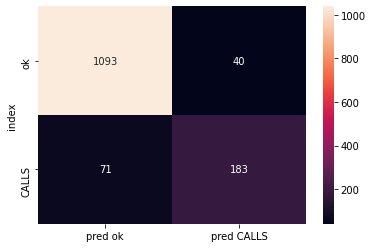

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cat = "CALLS"
pred_cat = "pred_" + cat

cm = pd.DataFrame(
    confusion_matrix(dev_df[cat], dev_df[pred_cat])
)

cm.columns = ["pred ok", "pred "+cat]

cm["index"] = ["ok", cat]

cm.set_index("index", inplace=True)

normalized = cm
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)


false_negatives = dev_df.loc[((~dev_df[pred_cat]) & (dev_df[cat])) != 0]

false_positives = dev_df.loc[((dev_df[pred_cat]) & (~dev_df[cat])) != 0]

columns = ["text", "context", "tokenized_text"] + [pred_cat, cat]
false_negatives = false_negatives[columns]
false_positives = false_positives[columns]

sns.heatmap(normalized, annot=cm, fmt="", robust=True)

In [47]:

false_negatives = dev_df.loc[((~dev_df[pred_cat]) & (dev_df[cat])) != 0]

false_positives = dev_df.loc[((dev_df[pred_cat]) & (~dev_df[cat])) != 0]

columns = ["text", "context", "tokenized_text"] + [pred_cat, cat]
false_negatives = false_negatives[columns]
false_positives = false_positives[columns]

In [48]:
pd.options.display.max_colwidth = 500

false_negatives.sample(10)

,text,context,tokenized_text,pred_CALLS,CALLS
id,,,,,
345445,"usuario Estas personas son asesinos,chorros,violadores,felicidad y narcos....en síntesis son una peste de la sociedad...ojalá el coronavirus haga justicia,esa justicia que muchos de los familiares de esas víctimas que fueron asesinadas por cada uno de estos HdP...",Coronavirus en Argentina: se levantó la protesta de los presos en la cárcel de Melchor Romero,"[CLS] usuario Estas personas son asesinos, chorros, violadores, felicidad y narcos.... en síntesis son una peste de la sociedad... ojalá el coronavirus haga justicia, esa justicia que muchos de los familiares de esas víctimas que fueron asesinadas por cada uno de estos HdP... [SEP]",0,1
363707,usuario bala,Manifestantes ingresaron a la Municipalidad de Olavarría para reclamar viviendas: los vinculan a Juan Grabois,[CLS] usuario bala [SEP],0,1
372436,usuario Pero q hijos de put*. Después hay q soportar a la familia llorar y victimizarse. Pero q los revienten!,La tiraron al piso para robarle el celular y le quebraron la pierna: “Gracias a que tenía la mochila puesta me salvé la espalda”,[CLS] usuario Pero q hijos de put [UNK]. Después hay q soportar a la familia llorar y victimizarse. Pero q los revienten! [SEP],0,1
376727,usuario Chinos hdp xq no se dejan de joder ojala se los lleve un tsunami,Brucelosis en China: se escapó una bacteria de un laboratorio y ya hay más de 3.000 enfermos,[CLS] usuario Chinos hdp xq no se dejan de joder ojala se los lleve un tsunami [SEP],0,1
374680,usuario Para cuando la patada en el orto del planeta a estos enfermitos mentales?????,Horror en China: encuentran a 5000 mascotas muertas embaladas en un depósito,[CLS] usuario Para cuando la patada en el orto del planeta a estos enfermitos mentales????? [SEP],0,1
342752,usuario Loci dejen de joder con lo de la sopa de murcielago..¡¡ Este virus es made in china por quilombos que en nuestra puta vida nos vamos a enterar..¡¡ Ni olvido ni perdón muerte al gobierno chino por lo que nos hicieron..,Coronavirus: las terribles imágenes del mercado donde se originó la pandemia,[CLS] usuario Loci dejen de joder con lo de la sopa de murcielago.. ¡ ¡ Este virus es made in china por quilombos que en nuestra puta vida nos vamos a enterar.. ¡ ¡ Ni olvido ni perdón muerte al gobierno chino por lo que nos hicieron.. [SEP],0,1
345455,usuario Marta pasame la carabina 😏,Coronavirus en Argentina: se levantó la protesta de los presos en la cárcel de Melchor Romero,[CLS] usuario Marta pasame la carabina [UNK] [SEP],0,1
372041,usuario VOLVÉ VIDELA. LLEVATE LOS A NEGROS CACOS ESTOS Y A TODOS LOS ZURDOS.,Motochorros mataron a un repartidor en Adrogué: hacía una semana que había empezado a trabajar con la camioneta de su papá,[CLS] usuario VOLVÉ VIDELA. LLEVATE LOS A NEGROS CACOS ESTOS Y A TODOS LOS ZURDOS. [SEP],0,1
388126,usuario Ojala les den BALA,Video: tres delincuentes golpearon al padre de un periodista para robarle el auto,[CLS] usuario Ojala les den BALA [SEP],0,1


In [49]:
false_positives.sample(10)

,text,context,tokenized_text,pred_CALLS,CALLS
id,,,,,
346218,usuario Vayan todos,"Pese a las medidas de prevención por el coronavirus, organizaciones de izquierda convocan a marchar el 24 de marzo",[CLS] usuario Vayan todos [SEP],1,0
364731,usuario ¡¡¡¡¡¡¡¡¡¡¡¡¡¡¡Y PEDILE UN DIÚ POR FAVOR!!!!!!!!!!,Tuvo a su séptima hija mujer y espera que sea ahijada del Presidente: “A Alberto sólo le pediría trabajo”,[CLS] usuario ¡ ¡ ¡ ¡ ¡ ¡ ¡ ¡ ¡ ¡ ¡ ¡ ¡ ¡ ¡ Y PEDILE UN DIÚ POR FAVOR!!!!!!!!!! [SEP],1,0
332222,usuario Ya ya que estamos al estar en Argentina como ilegales los mandamos de vuelta junto con EVO el violin,Los bolivianos que viven en Argentina podrán circular libremente para ir a votar el domingo,[CLS] usuario Ya ya que estamos al estar en Argentina como ilegales los mandamos de vuelta junto con EVO el violin [SEP],1,0
375439,usuario Por más que el hombre fusilara al ladrón esta perfecto,La declaración de un testigo del caso del jubilado que mató a un ladrón: “Levantaba la mano pidiendo ayuda y el hombre le volvió a disparar”,[CLS] usuario Por más que el hombre fusilara al ladrón esta perfecto [SEP],1,0
347048,usuario Por que no botan ese egipcio ni medico es por eso USA le retiro el soporte solo apoyan esos malditos chinos y su virus.,La OMS advirtió que “se está acelerando la pandemia y claramente no se llegó al pico”,[CLS] usuario Por que no botan ese egipcio ni medico es por eso USA le retiro el soporte solo apoyan esos malditos chinos y su virus. [SEP],1,0
376755,usuario usuario Chinos y la puta madre d\nQ los parió \nJuguemos todos al teg y ataquemos a chino viejo,Brucelosis en China: se escapó una bacteria de un laboratorio y ya hay más de 3.000 enfermos,[CLS] usuario usuario Chinos y la puta madre d Q los parió Juguemos todos al teg y ataquemos a chino viejo [SEP],1,0
352482,usuario usuario Que regresen todos esos grones que liberaron,Un preso que participó del motín en Devoto y fue liberado con la excusa del coronavirus salió a robar y fue herido en un tiroteo con la Policía,[CLS] usuario usuario Que regresen todos esos grones que liberaron [SEP],1,0
346179,usuario Dios hará justicia con estos sanguinarios los borrará del mapa,En China comenzó el tradicional Festival de Carne de Perro a pesar de la pandemia de coronavirus y una ONG intenta salvarlos,[CLS] usuario Dios hará justicia con estos sanguinarios los borrará del mapa [SEP],1,0
357052,usuario Esta perfecto... el planeta contra china... nuevos esclavos,Repudian una serie de declaraciones de Eduardo Feinmann sobre los chinos: “El planeta se va a ocupar de ustedes”,[CLS] usuario Esta perfecto... el planeta contra china... nuevos esclavos [SEP],1,0


## LGBTI

<AxesSubplot:ylabel='index'>

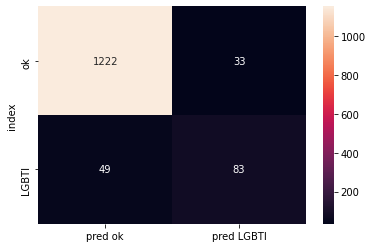

In [73]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cat = "LGBTI"
pred_cat = "pred_" + cat

cm = pd.DataFrame(
    confusion_matrix(dev_df[cat], dev_df[pred_cat])
)

cm.columns = ["pred ok", "pred "+cat]

cm["index"] = ["ok", cat]

cm.set_index("index", inplace=True)

normalized = cm
#normalized = (cm - cm.mean(axis=1)) / cm.std(axis=1)


false_negatives = dev_df.loc[((~dev_df[pred_cat]) & (dev_df[cat])) != 0]

false_positives = dev_df.loc[((dev_df[pred_cat]) & (~dev_df[cat])) != 0]

columns = ["text", "context", "tokenized_text"] + [pred_cat, cat]
false_negatives = false_negatives[columns]
false_positives = false_positives[columns]

sns.heatmap(normalized, annot=cm, fmt="", robust=True)

In [53]:
false_negatives

,text,context,tokenized_text,pred_LGBTI,LGBTI
id,,,,,
369361,"usuario y con el palo en la mano,no podía fallar viejo trolazo ajajajajajaja!!!!","El abuelo que a los 90 años confesó: “Soy gay, soy libre y estoy afuera”","[CLS] usuario y con el palo en la mano, no podía fallar viejo trolazo ajajajajajaja!!!! [SEP]",0,1
406058,usuario Estan mal de la cabeza..?,"Era soltero, se sumó a un matrimonio y ahora son una “tríada”: “Estoy enamorado de los dos”",[CLS] usuario Estan mal de la cabeza..? [SEP],0,1
406057,usuario 🤮🤮🤮🤮🤮🤮🤮,"Era soltero, se sumó a un matrimonio y ahora son una “tríada”: “Estoy enamorado de los dos”",[CLS] usuario [UNK] [SEP],0,1
394011,"usuario No importa si se mete penes de negro (BBC) en la colita o si tiene 23cm y gruesa entre las piernas. Lo que vale es que haga bien su trabajo, no es Miss Mundo, es secretarie de salude, o lo que fuere","Joe Biden nominó a Rachel Levine, una mujer transgénero, para que sea su subsecretaria de Salud","[CLS] usuario No importa si se mete penes de negro ( BBC ) en la colita o si tiene 23cm y gruesa entre las piernas. Lo que vale es que haga bien su trabajo, no es Miss Mundo, es secretarie de salude, o lo que fuere [SEP]",0,1
336373,"usuario Capaz si te ponías , el negro arrepentido q se tiñò de rubio, y encima es peronista..quizás tenías éxito... ☝️🤷🤪👀👀","La angustia de La Rubia Peronista por la crisis: “Estoy en un momento complicado, hago shows virtuales a la gorra”","[CLS] usuario Capaz si te ponías, el negro arrepentido q se [UNK] de rubio, y encima es peronista.. quizás tenías éxito... [UNK] [SEP]",0,1
367114,usuario Maraca peroncho arrepentido,"Negro Oro: “El día que se pueda, me voy a Uruguay hasta que pase todo”",[CLS] usuario Maraca peroncho arrepentido [SEP],0,1
373845,usuario De donde lo sacaron a este/a especie,"Pibita trans, activista negra, ni hombre ni mujer: ""Mi cuerpo es mi resistencia”",[CLS] usuario De donde lo sacaron a este [UNK] a especie [SEP],0,1
394008,usuario Que lindo como se les va a llenar el gobierno de zurdos!!! Otros q van a lamentar su voto en breve!!!,"Joe Biden nominó a Rachel Levine, una mujer transgénero, para que sea su subsecretaria de Salud",[CLS] usuario Que lindo como se les va a llenar el gobierno de zurdos!!! Otros q van a lamentar su voto en breve!!! [SEP],0,1
400531,usuario Afeitate las patas primero,Tucumán: masivo respaldo a un joven que fue al acto de graduación en pollera y las autoridades del colegio lo obligaron a cambiarse,[CLS] usuario Afeitate las patas primero [SEP],0,1


In [54]:
false_positives

,text,context,tokenized_text,pred_LGBTI,LGBTI
id,,,,,
377997,usuario Volvio Kondorito??,"Florencia Kirchner celebró el Día de la Lealtad con una imagen de Eva Duarte: “No hay tibieza que yo busque""",[CLS] usuario Volvio Kondorito?? [SEP],1,0
332994,"usuario Mira la foto. como ese engendro puede decir algo de otra persona. Es Se muestran resultados de chubaca\nBuscar, en cambio, Chewbacca con la cara depilada. Todavia no dejo de usar la pelela y quiere dar clases esta impresentable",Coronavirus: el exabrupto de Ofelia Fernández contra quienes se manifestaron contra la cuarentena,"[CLS] usuario Mira la foto. como ese engendro puede decir algo de otra persona. Es Se muestran resultados de chubaca Buscar, en cambio, Chewbacca con la cara depilada. Todavia no dejo de usar la pelela y quiere dar clases esta impresentable [SEP]",1,0
372584,usuario A éste zorete hay que hacerlo mierda!!! Y a los padres del pibe de 14 preguntarles que mierda estaban haciendo mientras su hijo estaba con éste hijo de un container de putas,Quién es el docente detenido por pedofilia que fue encontrado con un alumno en la cama,[CLS] usuario A éste zorete hay que hacerlo mierda!!! Y a los padres del pibe de 14 preguntarles que mierda estaban haciendo mientras su hijo estaba con éste hijo de un container de putas [SEP],1,0
363405,"usuario Advertencias, amenaza, información. Cómo sabe estas cosas este Gil? Algún Fiscal???? Nadie con huevos, hacen esto para que tengamos miedo y no salgamos. Hay que empezar a bajar Chorros",Juan Grabois: “Hay una oleada de toma de tierras que se va a profundizar”,"[CLS] usuario Advertencias, amenaza, información. Cómo sabe estas cosas este Gil? Algún Fiscal???? Nadie con huevos, hacen esto para que tengamos miedo y no salgamos. Hay que empezar a bajar Chorros [SEP]",1,0
389419,"usuario Volve al gancho , docer",El senador José Mayans defendió a Gildo Insfrán: “En pandemia no hay derechos”,"[CLS] usuario Volve al gancho, docer [SEP]",1,0
329326,usuario lo unico que sabe hacer es chupar la ver** de un rico,Denuncian a Verónica Ojeda y el jefe de gabinete de Sergio Berni por violar la cuarentena y agredir a oficiales de la bonaerense,[CLS] usuario lo unico que sabe hacer es chupar la ver [UNK] [UNK] de un rico [SEP],1,0
408240,usuario Pero los huevos que tuvo el que te cogió son impresionantes!!! O era ciego🤔🤔,"Relato de un aborto en medio de la desesperación: “Me jugué la vida, cuando no tenés plata te la jugás”",[CLS] usuario Pero los huevos que tuvo el que te cogió son impresionantes!!! O era [UNK] [SEP],1,0
356897,usuario La resen,Río Gallegos: una mujer destruyó a palazos el auto de alta gama de su ex pareja,[CLS] usuario La resen [SEP],1,0
350384,"usuario Boluda importante, sus hijaa comen carne, no le da la cabeza, mucha tintura",Nicole Neumann apuntó contra los consumidores de carne: “Sigan comiendo asadito”,"[CLS] usuario Boluda importante, sus hijaa comen carne, no le da la cabeza, mucha tintura [SEP]",1,0


In [12]:

from hatedetection.predict import predict_category

def predict(sentence, context=None):
    return predict_category(model, tokenizer, sentence, context=context)

In [13]:
predict("Negro chorro de mierda")

['RACISM']

In [14]:
predict("Quiere bija")

['LGBTI']

In [15]:
predict("Es una tortillera")

['WOMEN']

In [16]:
predict("Le falta verga")

['WOMEN']

In [17]:
predict("Metanles bala!")

['CALLS', 'CRIMINAL']

In [18]:
predict("Volvete a Israel!")

['CALLS', 'RACISM']

In [19]:
predict("Volvete a Arabia, musulmán!")

['RACISM']

In [20]:
predict("Habría que limitar el acceso inmediatamente de todo oriental")

['CALLS', 'RACISM']

In [21]:
predict("Te llamás Raúl querido")

['LGBTI']

In [22]:
predict("No seas trolo viejo")

['LGBTI']

In [23]:
predict("A esta TAPU hay que agarrarla de a varios para que sepa lo que es bueno")

['WOMEN']

Acá no encuentra el llamado a la acción...ahora, si lo cambiamos ligeramente...

In [ ]:
predict("A esta negra de mierda hay que agarrarla de a varios para que sepa lo que es bueno")

In [ ]:
predict("Hay que encerrar a todos estos homosexuales de mierda")

In [ ]:
predict("Qué asco de putos")

In [ ]:
predict("Hay que matar a todos los gorilas")

Parece que correlaciona todo llamado a la acción a los criminales

In [ ]:
predict("orientales")

In [ ]:
predict("Estos come murciélagos te apagan la heladera a la tarde")

In [ ]:
predict("Negros chorros de mierda, cuarenta ladrillos y arreglamos esto")

In [ ]:
predict("negras al paredón!")

In [ ]:
predict("No queremos rojitos acá")

In [ ]:
predict("No les gusta laburar eh")

In [ ]:
predict("Agarrá la pala!")

In [ ]:
predict("Agarrá la pala, vago!")

In [ ]:
predict("Menos ganas de laborar eh")

In [ ]:
predict("Viven del Estado, esta gente sinceramente no tiene remedio")

In [ ]:
predict("Tenés dos pelotas entre las piernas amigazo")

In [ ]:
predict("jajajajaj pero ni por puta casualidad laburar, no?")

In [ ]:
predict("más topu imposible")

In [ ]:
predict("hay que mandarlos a un campo de concentración a estos musulmanes")

In [ ]:
predict("Fuera rusos!")

In [ ]:
predict("Todos los indios son una caca que sólo merece morir")

In [ ]:
predict("los judíos merecen morir")

In [ ]:
predict("los chorros merecen morir")

In [ ]:
predict("los piqueteros merecen morir")

In [ ]:
predict("los palestinos merecen morir")

In [ ]:
predict("los homosexuales merecen morir")

In [ ]:
predict("los homosexuales tienen que ser aislados de la sociedad")

In [ ]:
predict("los presos tienen que ser aislados de la sociedad")

In [ ]:
predict("los criminales tienen que ser aislados de la sociedad")

In [ ]:
predict("los españoles tienen que ser aislados de la sociedad")

In [ ]:
predict("los chinos tienen que ser aislados de la sociedad")

In [ ]:
predict("los italianos tienen que ser aislados de la sociedad")

In [ ]:
predict("los italianos deben ser fusilados")